# BO comparisons in 1D

Now I've made a modular implementation of a BO loop using BoTorch. Next, I'll compare many acquisition functions in different settings, focusing on 1D functions in this notebook. 

# Standard acquisition functions

In [18]:
import warnings

import matplotlib.pyplot as plt
import seaborn as sns
import torch

from molbo.acquisition import *
from molbo.bo import BOLoop, BOMetrics
from molbo.models import GPModel
from molbo.utils.functions import Toy1DFunction
from molbo.utils.logger import WandBLogger

warnings.filterwarnings("ignore")

sns.set_style("whitegrid")
sns.set_palette("muted")


device = "cuda" if torch.cuda.is_available() else "cpu"
DTYPE = torch.float64
t_params = {
    'device': device,
    'dtype': DTYPE,
}

print(f"Device: {device}\nData type: {DTYPE}")

Device: cpu
Data type: torch.float64


In [22]:
def run_experiment(acq, n_trials: int = 5):

    for i in range(n_trials):

        run_name = f"{acq.__name__}_trial_{i+1}"

        logger = WandBLogger(
            project_name="molbo",
            group_name=acq.__name__,
            run_name=run_name,
            mode="disabled",
        )

        f = Toy1DFunction()
        bounds = f.bounds

        # Generate 3 random samples
        n_init = 3
        train_X = bounds[1] * torch.rand(n_init, 1, **t_params)
        train_y = f(train_X).unsqueeze(-1)

        model = GPModel(train_X, train_y)
        acq_func = acq(model)
        metrics = BOMetrics(f_max = f.max, logger=logger)
        bo_loop = BOLoop(model, acq_func, f, metrics=metrics)
        bo_loop.run(n_iters=10)

        logger.finish()

    return metrics

In [48]:
ei = EIAcquisition
log_ei = LogEIAcquisition
pi = PIAcquisition
log_pi = LogPIAcquisition
ucb = UCBAcquisition
ts = TSAcquisition
kg = KGAcquisition

acquisitions = [ei, log_ei, pi, log_pi, ucb, ts, kg]

In [49]:
metrics = []
for acq in acquisitions:
    print(f"Running experiment with acquisition function: {acq.__name__}")
    metrics.append(run_experiment(acq))

Running experiment with acquisition function: EIAcquisition
Running experiment with acquisition function: LogEIAcquisition
Running experiment with acquisition function: PIAcquisition
Running experiment with acquisition function: LogPIAcquisition
Running experiment with acquisition function: UCBAcquisition
Running experiment with acquisition function: TSAcquisition
Running experiment with acquisition function: KGAcquisition


In [50]:
ei_results = metrics[0].compute_metrics()
log_ei_results = metrics[1].compute_metrics()
pi_results = metrics[2].compute_metrics()
log_pi_results = metrics[3].compute_metrics()
ucb_results = metrics[4].compute_metrics()
ts_results = metrics[5].compute_metrics()
kg_results = metrics[6].compute_metrics()

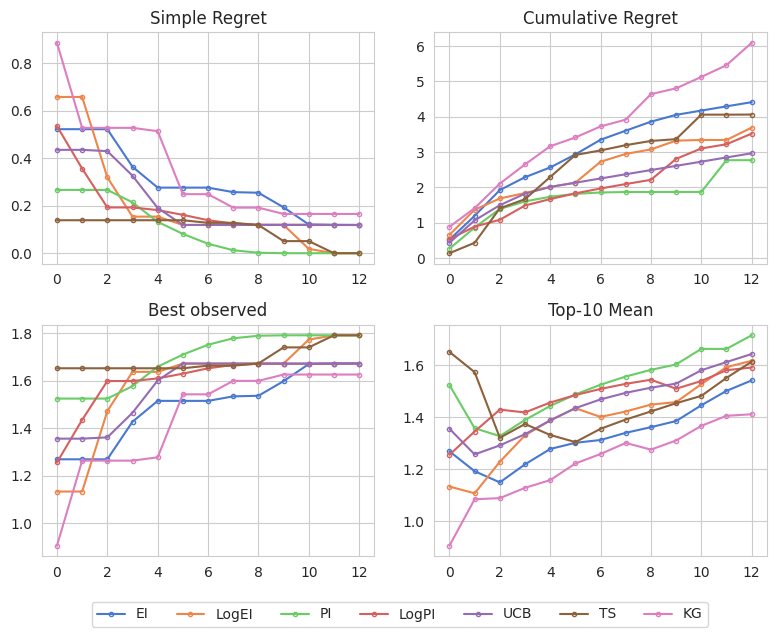

In [72]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 6))

markersize= 3

# Plot simple regrets
ax = axes[0, 0]
metric = 'simple_regret'

ax.plot(ei_results[metric], marker='o', markersize=markersize, markerfacecolor='none')
ax.plot(log_ei_results[metric], marker='o', markersize=markersize, markerfacecolor='none')
ax.plot(pi_results[metric], marker='o', markersize=markersize, markerfacecolor='none')
ax.plot(log_pi_results[metric], marker='o', markersize=markersize, markerfacecolor='none')
ax.plot(ucb_results[metric], marker='o', markersize=markersize, markerfacecolor='none')
ax.plot(ts_results[metric], marker='o', markersize=markersize, markerfacecolor='none')
ax.plot(kg_results[metric], marker='o', markersize=markersize, markerfacecolor='none')

ax.set_title("Simple Regret")


# Plot cumulative regrets
ax = axes[0, 1]
metric = 'cumulative_regret'

ax.plot(ei_results[metric], marker='o', markersize=markersize, markerfacecolor='none')
ax.plot(log_ei_results[metric], marker='o', markersize=markersize, markerfacecolor='none')
ax.plot(pi_results[metric], marker='o', markersize=markersize, markerfacecolor='none')
ax.plot(log_pi_results[metric], marker='o', markersize=markersize, markerfacecolor='none')
ax.plot(ucb_results[metric], marker='o', markersize=markersize, markerfacecolor='none')
ax.plot(ts_results[metric], marker='o', markersize=markersize, markerfacecolor='none')
ax.plot(kg_results[metric], marker='o', markersize=markersize, markerfacecolor='none')

ax.set_title("Cumulative Regret")

# Plot best observed
ax = axes[1, 0]
metric = 'best_observed'

ax.plot(ei_results[metric], marker='o', markersize=markersize, markerfacecolor='none')
ax.plot(log_ei_results[metric], marker='o', markersize=markersize, markerfacecolor='none')
ax.plot(pi_results[metric], marker='o', markersize=markersize, markerfacecolor='none')
ax.plot(log_pi_results[metric], marker='o', markersize=markersize, markerfacecolor='none')
ax.plot(ucb_results[metric], marker='o', markersize=markersize, markerfacecolor='none')
ax.plot(ts_results[metric], marker='o', markersize=markersize, markerfacecolor='none')
ax.plot(kg_results[metric], marker='o', markersize=markersize, markerfacecolor='none')

ax.set_title("Best observed")

# Plot top-10 mean
ax = axes[1, 1]
metric = 'topk_mean'

ax.plot(ei_results[metric], marker='o', markersize=markersize, markerfacecolor='none', label="EI")
ax.plot(log_ei_results[metric], marker='o', markersize=markersize, markerfacecolor='none', label="LogEI")
ax.plot(pi_results[metric], marker='o', markersize=markersize, markerfacecolor='none', label="PI")
ax.plot(log_pi_results[metric], marker='o', markersize=markersize, markerfacecolor='none', label="LogPI")
ax.plot(ucb_results[metric], marker='o', markersize=markersize, markerfacecolor='none', label="UCB")
ax.plot(ts_results[metric], marker='o', markersize=markersize, markerfacecolor='none', label="TS")
ax.plot(kg_results[metric], marker='o', markersize=markersize, markerfacecolor='none', label="KG")

ax.set_title("Top-10 Mean")
fig.legend(bbox_to_anchor=(.9, 0), ncols=7)

plt.tight_layout()

In [ ]:
# TODO:
# * plot 1d

# Noisy observations